BBB Project Part 2
===

- Shows performance of bayes by backprop, a method using Variational Inference on a network

## Import files: same as other BBB project parts

In [2]:
# Add local folders to path
import os, sys
sys.path.insert(1, os.path.join(sys.path[0], '..'))

In [3]:
from collections import OrderedDict

import pymc3 as pm
import theano
import theano.tensor as tt

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from scipy.stats import mode
from pymc3.theanof import set_tt_rng, MRG_RandomStreams

%matplotlib inline

In [4]:
print('PyMC3 v{}\nTheano v{}'.format(pm.__version__,theano.__version__))

PyMC3 v3.5
Theano v1.0.3


In [5]:
# Set random seeds
np.random.seed(42)
pm.set_tt_rng(42)

In [6]:
# Avoid warnings on batches below
from warnings import filterwarnings
filterwarnings('ignore')

In [7]:
# Use tensorflow to import image datasets
import tensorflow as tf

reshape_train_imgs = lambda img : img.reshape(img.shape[0],-1)
imgvec2img = lambda vec : vec.reshape((np.sqrt(vec.shape[0]).astype(int),np.sqrt(vec.shape[0]).astype(int)))
floatX = theano.config.floatX

dataset = 'fashion_mnist'

if dataset == 'mnist':
    (X_train, y_train), (X_test, y_test) = tf.keras.datasets.mnist.load_data()
    X_train,X_test = reshape_train_imgs(X_train),reshape_train_imgs(X_test)
    label_dict = OrderedDict({i:str(i) for i in range(10)})
    
    X_train = X_train.astype(floatX)/255
    y_train = y_train.astype(np.int)
    X_test = X_test.astype(floatX)/255
    y_test = y_test.astype(np.int)
    
    n_output = len(label_dict)
    
elif dataset == 'fashion_mnist':
    (X_train, y_train), (X_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()
    X_train,X_test = reshape_train_imgs(X_train),reshape_train_imgs(X_test)
    label_dict = OrderedDict({0: 'T-shirt/top',
                              1: 'Trouser',
                              2: 'Pullover',
                              3: 'Dress',
                              4: 'Coat',
                              5: 'Sandal',
                              6: 'Shirt',
                              7: 'Sneaker',
                              8: 'Bag',
                              9: 'Ankle boot'})
    X_train = X_train.astype(floatX)/255
    y_train = y_train.astype(np.int)
    X_test = X_test.astype(floatX)/255
    y_test = y_test.astype(np.int)
    
    n_output = len(label_dict)

(n_train,n_input) = X_train.shape
print("N Input for {} = {}".format(dataset,n_input))

N Input for fashion_mnist = 784


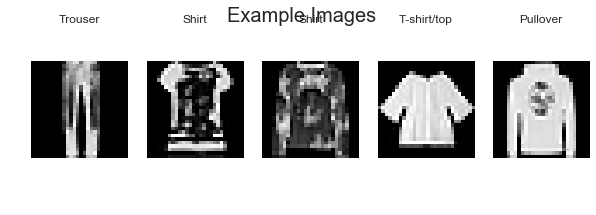

In [8]:
# PLot random subset of images
n_plot_samples = 5
rand_samps = np.random.choice(X_train.shape[0],size=n_plot_samples)

figsize = (10,3); fontsize = 16;
f, axs = plt.subplots(1,n_plot_samples,sharex=True,figsize=figsize);
for rs,ax in zip(rand_samps,axs):
    ax.imshow(imgvec2img(X_train[rs]),cmap='gray');
    ax.axis('off')
    ax.set_title(label_dict[y_train[rs]]);
    sns.despine();
f.suptitle("Example Images",fontsize=fontsize+4);

Use %load magic here to load `bbb_nn.py`. Delete are re-run a cell as below for updates:
```python
%load bbb_nn.py
```

In [238]:
# %load bbb_nn.py
def construct_nn(ann_input, ann_output, n_input, n_output, n_train, n_hidden_1=128):
    
    # Initialize random weights between each layer
    init_w_1 = np.random.randn(n_input, n_hidden_1).astype(theano.config.floatX)
    init_out = np.random.randn(n_hidden_1,n_output).astype(theano.config.floatX)
    
    with pm.Model() as neural_network:
        # Weights from input to hidden layer
        w_0_1 = pm.Normal('w_0_1', 0, sd=1, shape=(n_input, n_hidden_1), testval=init_w_1)
     
        # Weights from hidden layer to output
        w_1_out = pm.Normal('w_2_out', 0, sd=1,shape=(n_hidden_1,n_output),testval=init_out)

        # Build neural-network using tanh activation function
        act_1 = pm.Deterministic('act_1',var=pm.math.tanh(pm.math.dot(ann_input,w_0_1)))#+b_1))
        
        # Softmax is required at last layer
        act_out = pm.Deterministic('act_out',var=tt.nnet.softmax(pm.math.dot(act_1,w_1_out)))
    
        # Classification
        out = pm.Categorical('out',act_out,observed=ann_output,total_size=n_train)
        
    return neural_network

## Application: Active Learning with fashion_mnist

One of the main benefits of using a Bayesian Neural Network is that it is possile to drive learning online accoring to where the network is most uncertain. This is often referred to as active learning. We are going to apply active learning to training a BNN for classification on the fashion_mnist dataset. Our hope is that we can speed up learning by feeding the network data according to which categories it is the most uncertain about. 

**Brief Overview**

When we started working on this problem we were suprised to see that with a very small fraction of the training dataset we still got decent performance on the test set with our BNN. For example, with the full training dataset (60,000 images) we get a test set performance of 77%, while with only 300 data points we still get 71% performance. This was based on 10K iterations (~8 epochs), so it is possible that the assymptoic performance of the networks with this amount of data would be more different. In any case, these findings made us interested in how performance depends on the number of data points. 

In order to investigate this we trained a network on varying amounts of training data. This would have taken a very long time with our BNN, so instead we used a network with the same structure, but trained with adam in tensorflow. We found that the learning curve as a function of training data is highly nonlinear. Specifically, there is a large increase in performance between 50 and 200 training data points, and then a linear increase between 200 and 60000. 

For the purpose of exploring active learning with this example dataset, we are going to focus on speeding up the improvement in performance within the first ~500 training data points seen. 

**Outline**

1. Get an idea the learning curve as a function of the amount of training data
2. Example of training on subset of data and assessing uncertainty
3. Active learning application

### 1) Assess test performance as a function of number of training data points

Before moving on with active learning, we want to get a sense of how test set performace depends on the number of training samples. It would be pretty slow to look at this with out pymc3 model, but we can use Adam optimization in tensorflow to get an idea of the learning curve on an ANN. 

In [234]:
from tensorflow import keras

def tf_model(X_train, y_train):
    model = keras.Sequential([
        keras.layers.Dense(128, activation=tf.nn.tanh),
        keras.layers.Dense(n_output, activation=tf.nn.softmax)
    ])

    model.compile(optimizer=tf.train.AdamOptimizer(), 
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

    model.fit(X_train, y_train, epochs=5)
    test_loss, test_acc = model.evaluate(X_test, y_test)
    
    return test_acc
    
test_acc = tf_model(X_train, y_train)
print('Test accuracy:', test_acc)

Epoch 1/5
60000/60000 [==============================] - 9s 144us/step - loss: 0.4764 - acc: 0.8297
Epoch 2/5
60000/60000 [==============================] - 6s 104us/step - loss: 0.3677 - acc: 0.8671
Epoch 3/5
60000/60000 [==============================] - 6s 97us/step - loss: 0.3338 - acc: 0.8777
Epoch 4/5
60000/60000 [==============================] - 6s 92us/step - loss: 0.3112 - acc: 0.8851
Epoch 5/5
10000/10000 [==============================] - 0s 49us/step
Test accuracy: 0.8777


In [252]:
# n_samples_vec = [10,20, 30, 40, 50, 70, 100, 150, 200, 500, 1000, 10000, 60000]

# n_trials = 10
# test_acc_results = np.zeros((len(n_samples_vec), n_trials))
# for i, n_samples in enumerate(n_samples_vec):
#     print(n_samples)
#     for j in range(n_trials):
#         X_train_subset, y_train_subset = get_training_subset(X_train, y_train, n_samples)
#         test_acc = tf_model(X_train_subset, y_train_subset)
#         test_acc_results[i,j] = test_acc

# mean_perf = np.mean(test_acc_results, axis=1)
# std_perf = np.std(test_acc_results, axis=1)
# num_points_plot = 11
# plt.plot(n_samples_vec[:], mean_perf[:], c='blue')
# plt.fill_between(n_samples_vec[:], mean_perf[:num_points_plot]+std_perf[:], mean_perf[:num_points_plot]-std_perf[:], color='blue', alpha=.25)
# plt.show()

10000
Epoch 1/5
10000/10000 [==============================] - 44s 4ms/step - loss: 0.6745 - acc: 0.7623
Epoch 2/5
10000/10000 [==============================] - 10s 958us/step - loss: 0.4704 - acc: 0.8378
Epoch 3/5
10000/10000 [==============================] - 9s 887us/step - loss: 0.4229 - acc: 0.8474
Epoch 4/5
10000/10000 [==============================] - 9s 882us/step - loss: 0.3876 - acc: 0.8654
Epoch 5/5
10000/10000 [==============================] - 27s 3ms/step
Epoch 1/5
10000/10000 [==============================] - 43s 4ms/step - loss: 0.6624 - acc: 0.7684
Epoch 2/5
10000/10000 [==============================] - 8s 830us/step - loss: 0.4697 - acc: 0.8303
Epoch 3/5
10000/10000 [==============================] - 9s 926us/step - loss: 0.4237 - acc: 0.8475
Epoch 4/5
10000/10000 [==============================] - 9s 947us/step - loss: 0.3832 - acc: 0.8631
Epoch 5/5
10000/10000 [==============================] - 23s 2ms/step
Epoch 1/5
10000/10000 [==============================] 

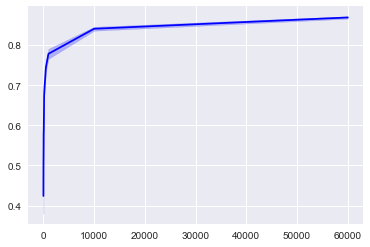

In [273]:
with open('perf_training_subset_v2.pickle', 'rb') as f:
    perf_training_subset = pickle.load(f)

plt.plot(perf_training_subset['num_training'], perf_training_subset['mean'], c='blue')
plt.fill_between(perf_training_subset['num_training'], 
                 perf_training_subset['mean'] + perf_training_subset['std'],
                 perf_training_subset['mean'] -  perf_training_subset['std'],
                 color='blue' , alpha=.25)
plt.show()


The relationship between the number of training data points and test set performance is highly nonlinear. We see a large jump in performance between 10 and 200 training data points, and then a slight increase from then on. As mentioned abve, we are going to focus on increasing the speed of learning at the beginning of training (~500 training points). 

### 2) Example of training network on subset of data and assessing uncertainty


We will now go through an example of training a BNN on a subset of the data. We will used a balanced subset of 200 training data points. As we will from the confusion matrix, there is an uneven distribution of uncertainty across categories. Hopefully by using active learning, we can give the network appropraite data during training to efficiently reduce the uncertainty.  

#### Functions for trainining on subset and assessing uncertainty

In [20]:
import scipy as sp

def get_training_subset(X_train, y_train, n_samples):
    (n_train, n_input) = np.shape(X_train)
    n_cat = 10
    if n_train == n_samples:
        return X_train, y_train
    # make n_samples a multiple of 10 for ease of balancing the dataset
    n_cat_samples = int(n_samples/10)
    # get appropraite number of samples from each category
    cat_ind = list()
    ind_array = np.arange(n_train)
    for cat in range(n_cat):
        cat_ind = np.append(cat_ind, np.random.choice(ind_array[y_train == cat], size=n_cat_samples, replace=False))
    np.random.shuffle(cat_ind)
    X_train_subset = X_train[cat_ind.astype(int)]
    y_train_subset = y_train[cat_ind.astype(int)]
    return X_train_subset, y_train_subset

def get_cat_entropy(X_test, y_test, ppc_test):
    # get other parameters that need
    (n_test,n_input) = X_test.shape
    n_output = 10
    n_samples = np.shape(ppc_test['out'])[0]
    
    # make one-hot matrix
    one_hot = np.zeros((n_samples, n_test, n_output))
    for i in range(n_samples):
        one_hot[i][np.arange(n_test), ppc_test['out'][i]] = 1
    
    # make histograms 
    y_test_dist = np.histogram(y_test, bins=n_output)[0]
    cat_hist = np.zeros((n_output, n_output))
    cat_entropy = np.zeros(n_output)
    cat_KL = np.zeros(n_output)
    histograms = np.sum(one_hot, axis=0)
    for i in range(n_output):
        cat_hist[i,:] = np.sum(histograms[y_test == i], axis=0)
        cat_entropy[i] = sp.stats.entropy(cat_hist[i,:])
        cat_KL[i] = sp.stats.entropy(cat_hist[i,:], y_test_dist)
#         cat_KL[i] = sp.stats.entropy(y_test_dist, cat_hist[i,:])
    return one_hot, cat_hist, cat_entropy, cat_KL

#### Train Network on subset of data

In [11]:
n_samples = 200
X_train_subset, y_train_subset = get_training_subset(X_train, y_train, n_samples)

NN_model = construct_nn(X_train_subset, y_train_subset, n_input, n_output, n_samples, n_hidden_1=128)

In [12]:
# convergence not great, use a different method for conv check after:
# https://docs.pymc.io/notebooks/variational_api_quickstart.html
with NN_model:
    advi = pm.ADVI()
    
# After the bayes by BackProp paper!
print(advi.approx.shared_params)

n_approx_iter = 10000
with NN_model:
    approx = advi.fit(n=n_approx_iter)

{'mu': mu, 'rho': rho}


Average Loss = 5,215.8: 100%|██████████| 10000/10000 [02:51<00:00, 67.64it/s]
Finished [100%]: Average Loss = 5,207.9


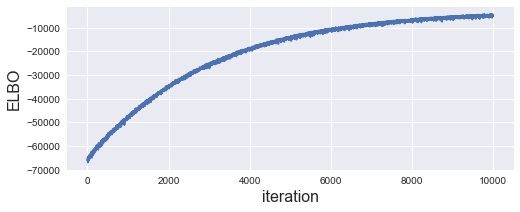

In [13]:
# plotting the training progress
elbo_1 = -advi.hist

figsize = (8,3); fontsize = 16;
f, ax = plt.subplots(1,1,figsize=figsize);

ax.plot(elbo_1,label='1')
ax.set_ylabel('ELBO',fontsize=fontsize)
ax.set_xlabel('iteration',fontsize=fontsize);
sns.despine();

#### Test this network performance on test set

In [14]:
# Draw samples from variational posterior (the weights in the network)
n_draws = 500 # > 2k hangs for almost all network sizes on my 2018 MBP -SH
trace = approx.sample(draws=n_draws)

In [15]:
# network at performance on the test set
(n_test,n_input) = X_test.shape
test_x = theano.shared(X_test)
test_y = theano.shared(y_test)
NN_model_test = construct_nn(test_x, test_y, n_input, n_output, n_test, n_hidden_1=128)
n_samples = 100
with NN_model_test:
    ppc_test = pm.sample_ppc(trace, samples=n_samples)

100%|██████████| 100/100 [00:51<00:00,  2.01it/s]


In [16]:
# Prediction is mode of each
test_y_pred = mode(ppc_test['out'], axis=0).mode[0,:]

mean_test_perf = np.mean(test_y_pred==y_test)
print("Network Test Set Performance: {:f}".format(mean_test_perf))

Network Test Set Performance: 0.704600


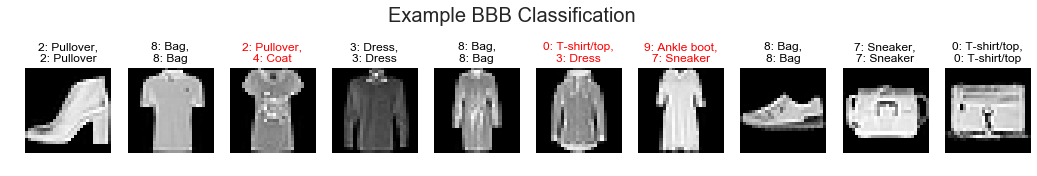

In [17]:
# PLot random subset of images
n_plot_samples = 10
rand_samps = np.random.choice(X_test.shape[0],size=n_plot_samples)

figsize = (18,3); fontsize = 16;
f, axs = plt.subplots(1, n_plot_samples, figsize=figsize);

for rs,ax in zip(rand_samps,axs):
    ax.imshow(imgvec2img(X_train[rs]),cmap='gray');
    tl = "{}: {},\n{}: {}".format(test_y_pred[rs],label_dict[test_y_pred[rs]],y_test[rs],label_dict[y_test[rs]])
    if test_y_pred[rs] == y_test[rs]:
        ax.set_title(tl,color='k');
    else:
        ax.set_title(tl,color='r');
    ax.axis('off');
    sns.despine();
    
f.suptitle("Example BBB Classification",fontsize=fontsize+4);

#### Evaluate uncertainty within each category

Here we are measurign uncertainty as the KL between the network categorization and the actual distribution of y labels. If the training set is balance, the distribution of y labels will be a uniform distibution. A category that outputs almost a unifrom distribution is very uncertain (low KL), while a network that outputs something close to a one-hot vector is very certain (high KL). Consequently, a category with low KL has high uncertainty, and a category with high KL has low uncertainty.

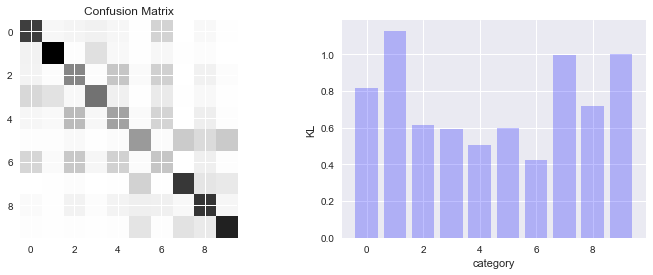

In [368]:
fig, ax = plt.subplots(1,2, figsize=(12,4))

one_hot, cat_hist, cat_entropy, cat_KL = get_cat_entropy(X_test, y_test, ppc_test)
ax[0].imshow(cat_hist)
ax[0].set_title('Confusion Matrix')
ax[1].bar(np.arange(10), cat_KL, color='blue', alpha=.25)
# plt.legend()
ax[1].set_xlabel('category')
ax[1].set_ylabel('KL')

plt.show()

These results are pretty interesting. We already get pretty good performance (70%), but it is clear that the middle categories are much more uncertain than the outer categories. We will see if we can remedy this with active learning. 

### 3) Full example

#### Pseudocode

- Train network on subset of training data
- while num_training_data_used < 500
    - assess category uncertainty of network
    - choose 5 training samples from  category with largest uncertainty 
    - choose already seen training data to replay proportional to category uncertainty
    - train network using replay plus new data

**1) How to assess uncertainty while training?** In order to assess the uncertainty of the network we are going to test the network on training data that it has already seen. We want to assess this prior to feeding the network more data. If we were to assess the uncertainty on all seen data, this would take a long time. The benefit of the BBN is that we can get a measure of uncertainty for a single data point. This is still a bit noisy if we want to find the overal category with the highest uncertainty. We choose to assess the uncertainty using 3 data points from each category. 

**2) How many data points should we feed the network after assessing the uncertainty?** We want to avoid overfitting by feeding the network tons of data in a row from the same category. In order to avoid this we will feed the network data in chunks of 5. Also, since the uncertainty assessment is bound to be slightly noisy, we will probably not consistently identify one category as the most uncertain. This will also help avoid overfitting. 

**3) How to use multiple epochs with active learning?** One complication that comes up with active learning is how to adapt the idea of training over multiple epochs of the data. The example aboce runs through about 8 epochs of the training set subset. If it only does 1 epoch, performance is much worse. In order to mimic going though multiple epochs, we will introduce experience replay in conjunction with active learning. For expereince replay, we will choose 10 already seen training points in proportion to the uncertainty of each category.  

#### Helper functions for active learning

Variables to keep track of: 
- ind_used: nested list of used training samples
- ind_remaining: nested list of remaining training samples


In [341]:
def get_training_subset_init(X_train, y_train, n_samples):
    # make n_samples a multiple of 10 for ease of balancing the dataset
    n_cat = 10
    n_cat_samples = int(n_samples/10)
    n_train = np.shape(X_train)[0]
    ind_array = np.arange(n_train)
    
    # make cat list
    ind_remaining = list()
    for i in range(10):
        ind_remaining.append(ind_array[y_train == i])
    
    ind_used = [[]]*n_cat
    ind_subset = list()
    for cat in range(n_cat):
        cat_ind = np.random.choice(ind_remaining[cat], size=n_cat_samples, replace=False).astype(int)
        ind_remaining[cat] = np.delete(ind_remaining[cat], np.argwhere(np.in1d(ind_remaining[cat], cat_ind)))
        ind_used[cat] = np.append(ind_used[cat], cat_ind)
        ind_subset = np.append(ind_subset, cat_ind)
    ind_subset = ind_subset.astype(int)
    np.random.shuffle(ind_subset)
    X_train_subset = X_train[ind_subset]
    y_train_subset = y_train[ind_subset]
    return X_train_subset, y_train_subset, ind_used, ind_remaining

def get_cat_subset(X_train, y_train, ind_used, ind_remaining, n_samples, cat):
    # get appropraite number of samples from given category
    cat_ind = np.random.choice(ind_remaining[cat], size=n_samples, replace=False).astype(int)
    ind_used[cat] = np.append(ind_used[cat], cat_ind)
    ind_remaining[cat] = np.delete(ind_remaining[cat], np.argwhere(np.in1d(ind_remaining[cat], cat_ind)))
    X_train_subset = X_train[cat_ind]
    y_train_subset = y_train[cat_ind]
    return X_train_subset, y_train_subset, ind_used, ind_remaining

def get_used_subset(X_train, y_train, ind_used, n_samples):
    n_cat = 10
    n_cat_samples = int(n_samples/n_cat)
    cat_ind_list = list()
    for cat in range(n_cat):
        cat_ind = np.random.choice(ind_used[cat], size=n_cat_samples, replace=False)
        cat_ind_list = np.append(cat_ind_list, cat_ind)
    cat_ind_list = cat_ind_list.astype(int)
    X_used_subset = X_train[cat_ind_list]
    y_used_subset = y_train[cat_ind_list]
    return X_used_subset, y_used_subset

def get_max_uncertainty(X_train, y_train, ind_used, n_samples):
    X_used_subset, y_used_subset = get_used_subset(X_train, y_train, ind_used, n_samples)
    (n_test,n_input) = X_test.shape
    X_used_shared = theano.shared(X_used_subset)
    y_used_shared = theano.shared(y_used_subset)
    n_input = 28*28
    n_output = 10
    NN_model_test = construct_nn_active_learning(X_used_shared, y_used_shared, n_input, n_output, n_hidden=128)
    n_samples = 100
    with NN_model_test:
        ppc_test = pm.sample_ppc(trace, samples=n_samples)
    one_hot, cat_hist, cat_entropy, cat_KL = get_cat_entropy(X_used_subset, y_used_subset, ppc_test)
    return cat_KL, np.argmin(cat_KL)

def get_replay_subset(X_train, y_train, ind_used, cat_KL, n_samples, replay_ind_list):
    cat_KL_scaled = ((cat_KL - np.min(cat_KL))/(np.max(cat_KL) - np.min(cat_KL)))
    p_vals = (1 - cat_KL_scaled)/np.sum(cat_KL_scaled)
    p_vals /= np.sum(p_vals)
    n_cat_samples = np.round((p_vals*n_samples)).astype(int)
    cat_ind_list = list()
    for cat, n_cat_samp in enumerate(n_cat_samples):
        if n_cat_samp < len(ind_used[cat]):
            cat_ind = np.random.choice(ind_used[cat], size=n_cat_samp, replace=False)
        elif n_cat_samp > len(ind_used[cat]):
            cat_ind = ind_used[cat]
            n_ind_left = n_cat_samp - len(ind_used[cat])
            ind_used_list = [item for cat_used in ind_used for item in cat_used]
            extra_ind = np.random.choice(ind_used_list, size=n_ind_left, replace=False)
            cat_ind = np.append(cat_ind, extra_ind[0])
        elif n_cat_samp == len(ind_used[cat]):
            cat_ind = ind_used[cat]
        cat_ind_list = np.append(cat_ind_list, cat_ind)
    cat_ind_list = cat_ind_list.astype(int)
    X_replay_subset = X_train[cat_ind_list]
    y_replay_subset = y_train[cat_ind_list]
    replay_ind_list = np.append(replay_ind_list, cat_ind_list)
    return X_replay_subset, y_replay_subset, replay_ind_list

def get_replay_subset_balanced(X_train, y_train, ind_used, n_samples, replay_ind_list):
    n_cat = 10
    n_cat_samp = int(n_samples/n_cat)
    cat_ind_list = list()
    for cat in range(n_cat):
        if n_cat_samp < len(ind_used[cat]):
            cat_ind = np.random.choice(ind_used[cat], size=n_cat_samp, replace=False)
        elif n_cat_samp >= len(ind_used[cat]):
            cat_ind = ind_used[cat]
        cat_ind_list = np.append(cat_ind_list, cat_ind)
    cat_ind_list = cat_ind_list.astype(int)
    X_replay_subset = X_train[cat_ind_list]
    y_replay_subset = y_train[cat_ind_list]
    replay_ind_list = np.append(replay_ind_list, cat_ind_list)
    return X_replay_subset, y_replay_subset, replay_ind_list

#### Neural network for active learning

This network is identical to the BNN used above, expect that we are no longer using minibatches

In [202]:
# %load bbb_nn.py
def construct_nn_active_learning(ann_input, ann_output, n_input, n_output, n_hidden=128):
    
    # Initialize random weights between each layer
    init_w_1 = np.random.randn(n_input, n_hidden).astype(theano.config.floatX)
    init_out = np.random.randn(n_hidden,n_output).astype(theano.config.floatX)
    
    with pm.Model() as neural_network:
        # Weights from input to hidden layer
        w_0_1 = pm.Normal('w_0_1', 0, sd=1, shape=(n_input, n_hidden), testval=init_w_1)
     
        # Weights from hidden layer to output
        w_1_out = pm.Normal('w_2_out', 0, sd=1,shape=(n_hidden,n_output),testval=init_out)

        # Build neural-network using tanh activation function
        act_1 = pm.Deterministic('act_1',var=pm.math.tanh(pm.math.dot(ann_input,w_0_1)))#+b_1))
        
        # Softmax is required at last layer
        act_out = pm.Deterministic('act_out',var=tt.nnet.softmax(pm.math.dot(act_1,w_1_out)))
    
        # Classification
        out = pm.Categorical('out',act_out,observed=ann_output)
        
    return neural_network

#### Active learning functions

In [264]:
def initialize_network(X_train, y_train, n_samples, n_epochs, n_hidden):
    X_train_init, y_train_init, ind_used, ind_remaining = get_training_subset_init(X_train, y_train, n_samples)
    shared_x = theano.shared(X_train_init)
    shared_y = theano.shared(y_train_init)

    # make neural network
    (n_train,n_input) = X_train_init.shape
    n_output = 10
    NN_model = construct_nn_active_learning(shared_x, shared_y, n_input, n_output, n_hidden=n_hidden)

    # train network on initial subset of data
    n_approx_iter = n_samples*n_epochs
    with NN_model:
        advi = pm.ADVI()
        approx = advi.fit(n=n_approx_iter)
        
    return NN_model, advi, approx, ind_used, ind_remaining

def run_active_learning(NN_model_active, advi_active, ind_used, ind_remaining, n_active_learning_iterations, n_test_uncertainty,
                        n_cat_data_points, n_replay_data_points):
    i = 1
    replay_ind_list = ()
    while i < n_active_learning_iterations: #samples_remaining:
        print(i)
        # evaluate current uncertainty and find category with max uncertainty
        cat_KL, cat = get_max_uncertainty(X_train, y_train, ind_used, n_test_uncertainty)
        # get n_cat_data_points new training data from that category
        X_train_cat, y_train_cat, ind_used, ind_remaining = \
                get_cat_subset(X_train, y_train, ind_used, ind_remaining, n_cat_data_points, cat)
        # get replay training data proportional to current uncertainty
        X_train_replay, y_train_replay, replay_ind_list = \
            get_replay_subset(X_train, y_train, ind_used, cat_KL, n_replay_data_points, replay_ind_list)
        # concatenate training data for this active learning iteration
        X_train_subset = np.vstack((X_train_cat, X_train_replay))
        y_train_subset = np.append(y_train_cat, y_train_replay)
        # continue training network on this data
        shared_x.set_value(X_train_subset)
        shared_y.set_value(y_train_subset)
        n_iterations = len(y_train_subset)
        with NN_model_active:
            approx_active = advi_active.fit(n=n_iterations)
        i += 1
    return advi_active, approx_active, ind_used, replay_ind_list
                        
def run_active_learning_control(NN_model_control, advi_control, ind_used, ind_remaining, n_active_learning_iterations,
                                n_cat_data_points, n_replay_data_points):
    i = 1
    replay_ind_list = list()
    while i < n_active_learning_iterations: #samples_remaining:
        print(i)
        # choose random category to feed data
        cat = np.random.choice(n_output)
        # get n_cat_data_points new training data from that category
        X_train_cat, y_train_cat, ind_used, ind_remaining = \
                get_cat_subset(X_train, y_train, ind_used, ind_remaining, n_cat_data_points, cat)
        # get balanced replay training data
        X_train_replay, y_train_replay, replay_ind_list = \
            get_replay_subset_balanced(X_train, y_train, ind_used, n_replay_data_points, replay_ind_list)
        # concatenate training data for this active learning iteration
        X_train_subset = np.vstack((X_train_cat, X_train_replay))
        y_train_subset = np.append(y_train_cat, y_train_replay)
        # continue training network on this data
        shared_x.set_value(X_train_subset)
        shared_y.set_value(y_train_subset)
        n_iterations = len(y_train_subset)
        with NN_model_control:
            approx_control = advi_control.fit(n=n_iterations)
        i += 1
    return advi_control, approx_control, ind_used, replay_ind_list

#### Run active learning and active learning control

In [342]:
n_initial_samples = 50
n_epochs = 4
n_hidden = 128

n_active_learning_iterations = 200
n_test_uncertainty = 50
n_cat_data_points = 5
n_replay_data_points = 50

print('RUNNING ACTIVE LEARNING')
# initialize model
NN_model_active, advi_active, approx_active, ind_used, ind_remaining = \
    initialize_network(X_train, y_train, n_initial_samples, n_epochs, n_hidden)
# run active learning
advi_active, approx_active, ind_used_active, replay_ind_list_active = run_active_learning(
    NN_model_active, advi_active, ind_used, ind_remaining, n_active_learning_iterations, 
    n_test_uncertainty, n_cat_data_points, n_replay_data_points)

print('RUNNING ACTIVE LEARNING CONTROL')
# initialize model
NN_model_control, advi_control, approx_control, ind_used, ind_remaining = \
    initialize_network(X_train, y_train, n_initial_samples, n_epochs, n_hidden)
# run active learning control
advi_control, approx_control, ind_used_control, replay_ind_list_control = run_active_learning_control(
    NN_model_control, advi_control, ind_used, ind_remaining, n_active_learning_iterations,
    n_cat_data_points, n_replay_data_points)

RUNNING ACTIVE LEARNING


Average Loss = 60,193: 100%|██████████| 200/200 [00:02<00:00, 69.73it/s]
Finished [100%]: Average Loss = 60,087


1


Average Loss = 57,071: 100%|██████████| 53/53 [00:00<00:00, 72.95it/s]
Finished [100%]: Average Loss = 57,052


2


Average Loss = 55,867: 100%|██████████| 52/52 [00:00<00:00, 69.29it/s]
Finished [100%]: Average Loss = 55,858


3


Average Loss = 54,585: 100%|██████████| 52/52 [00:00<00:00, 71.63it/s]
Finished [100%]: Average Loss = 54,573


4


Average Loss = 53,408: 100%|██████████| 53/53 [00:00<00:00, 71.42it/s]
Finished [100%]: Average Loss = 53,401


5


Average Loss = 52,182: 100%|██████████| 53/53 [00:00<00:00, 75.86it/s]
Finished [100%]: Average Loss = 52,162


6


Average Loss = 51,077: 100%|██████████| 54/54 [00:00<00:00, 69.76it/s]
Finished [100%]: Average Loss = 51,037


7


Average Loss = 49,871: 100%|██████████| 53/53 [00:01<00:00, 42.23it/s]
Finished [100%]: Average Loss = 49,847


8


Average Loss = 48,647: 100%|██████████| 54/54 [00:00<00:00, 58.94it/s]
Finished [100%]: Average Loss = 48,622


9


Average Loss = 47,626: 100%|██████████| 53/53 [00:00<00:00, 70.50it/s]
Finished [100%]: Average Loss = 47,601


10


Average Loss = 46,534: 100%|██████████| 54/54 [00:00<00:00, 64.65it/s]
Finished [100%]: Average Loss = 46,504


11


Average Loss = 45,444: 100%|██████████| 54/54 [00:00<00:00, 68.31it/s]
Finished [100%]: Average Loss = 45,432


12


Average Loss = 44,389: 100%|██████████| 53/53 [00:00<00:00, 74.48it/s]
Finished [100%]: Average Loss = 44,363


13


Average Loss = 43,368: 100%|██████████| 52/52 [00:00<00:00, 70.93it/s]
Finished [100%]: Average Loss = 43,363


14


Average Loss = 42,389: 100%|██████████| 54/54 [00:00<00:00, 67.39it/s]
Finished [100%]: Average Loss = 42,357


15


Average Loss = 41,444: 100%|██████████| 54/54 [00:00<00:00, 55.25it/s]
Finished [100%]: Average Loss = 41,407


16


Average Loss = 40,389: 100%|██████████| 54/54 [00:00<00:00, 67.94it/s]
Finished [100%]: Average Loss = 40,364


17


Average Loss = 39,495: 100%|██████████| 52/52 [00:00<00:00, 70.13it/s]
Finished [100%]: Average Loss = 39,483


18


Average Loss = 38,529: 100%|██████████| 52/52 [00:00<00:00, 62.24it/s]
Finished [100%]: Average Loss = 38,527


19


Average Loss = 37,577: 100%|██████████| 52/52 [00:00<00:00, 71.67it/s]
Finished [100%]: Average Loss = 37,568


20


Average Loss = 36,843: 100%|██████████| 57/57 [00:00<00:00, 67.80it/s]
Finished [100%]: Average Loss = 36,792


21


Average Loss = 35,950: 100%|██████████| 50/50 [00:00<00:00, 68.58it/s]
Finished [100%]: Average Loss = 35,885


22


Average Loss = 35,113: 100%|██████████| 51/51 [00:00<00:00, 70.53it/s]
Finished [100%]: Average Loss = 35,113


23


Average Loss = 34,264: 100%|██████████| 54/54 [00:00<00:00, 72.93it/s]
Finished [100%]: Average Loss = 34,248


24


Average Loss = 33,424: 100%|██████████| 52/52 [00:00<00:00, 65.98it/s]
Finished [100%]: Average Loss = 33,416


25


Average Loss = 32,634: 100%|██████████| 51/51 [00:00<00:00, 70.83it/s]
Finished [100%]: Average Loss = 32,634


26


Average Loss = 31,974: 100%|██████████| 53/53 [00:00<00:00, 57.94it/s]
Finished [100%]: Average Loss = 31,973


27


Average Loss = 31,232: 100%|██████████| 55/55 [00:00<00:00, 75.50it/s]
Finished [100%]: Average Loss = 31,207


28


Average Loss = 30,381: 100%|██████████| 51/51 [00:00<00:00, 54.42it/s]
Finished [100%]: Average Loss = 30,381


29


Average Loss = 29,703: 100%|██████████| 53/53 [00:00<00:00, 64.07it/s]
Finished [100%]: Average Loss = 29,692


30


Average Loss = 28,996: 100%|██████████| 52/52 [00:01<00:00, 51.69it/s]
Finished [100%]: Average Loss = 28,996


31


Average Loss = 28,344: 100%|██████████| 55/55 [00:00<00:00, 58.58it/s]
Finished [100%]: Average Loss = 28,310


32


Average Loss = 27,589: 100%|██████████| 55/55 [00:00<00:00, 71.96it/s]
Finished [100%]: Average Loss = 27,559


33


Average Loss = 26,906: 100%|██████████| 54/54 [00:00<00:00, 66.87it/s]
Finished [100%]: Average Loss = 26,902


34


Average Loss = 26,292: 100%|██████████| 54/54 [00:00<00:00, 54.65it/s]
Finished [100%]: Average Loss = 26,276


35


Average Loss = 25,635: 100%|██████████| 54/54 [00:00<00:00, 69.75it/s]
Finished [100%]: Average Loss = 25,623


36


Average Loss = 25,057: 100%|██████████| 52/52 [00:00<00:00, 72.10it/s]
Finished [100%]: Average Loss = 25,059


37


Average Loss = 24,475: 100%|██████████| 53/53 [00:00<00:00, 74.18it/s]
Finished [100%]: Average Loss = 24,462


38


Average Loss = 23,870: 100%|██████████| 53/53 [00:00<00:00, 71.12it/s]
Finished [100%]: Average Loss = 23,853


39


Average Loss = 23,286: 100%|██████████| 55/55 [00:00<00:00, 68.66it/s]
Finished [100%]: Average Loss = 23,255


40


Average Loss = 22,709: 100%|██████████| 51/51 [00:00<00:00, 65.76it/s]
Finished [100%]: Average Loss = 22,709


41


Average Loss = 22,186: 100%|██████████| 55/55 [00:00<00:00, 71.43it/s]
Finished [100%]: Average Loss = 22,172


42


Average Loss = 21,636: 100%|██████████| 53/53 [00:01<00:00, 46.16it/s]
Finished [100%]: Average Loss = 21,620


43


Average Loss = 21,112: 100%|██████████| 55/55 [00:00<00:00, 72.86it/s]
Finished [100%]: Average Loss = 21,093


44


Average Loss = 20,600: 100%|██████████| 54/54 [00:00<00:00, 59.42it/s]
Finished [100%]: Average Loss = 20,585


45


Average Loss = 20,071: 100%|██████████| 53/53 [00:00<00:00, 54.26it/s]
Finished [100%]: Average Loss = 20,066


46


Average Loss = 19,642: 100%|██████████| 56/56 [00:00<00:00, 71.44it/s]
Finished [100%]: Average Loss = 19,616


47


Average Loss = 19,070: 100%|██████████| 55/55 [00:00<00:00, 71.21it/s]
Finished [100%]: Average Loss = 19,067


48


Average Loss = 18,633: 100%|██████████| 52/52 [00:00<00:00, 72.12it/s]
Finished [100%]: Average Loss = 18,632


49


Average Loss = 18,193: 100%|██████████| 55/55 [00:00<00:00, 76.08it/s]
Finished [100%]: Average Loss = 18,177


50


Average Loss = 17,702: 100%|██████████| 53/53 [00:00<00:00, 69.85it/s]
Finished [100%]: Average Loss = 17,691


51


Average Loss = 17,317: 100%|██████████| 54/54 [00:01<00:00, 47.98it/s]
Finished [100%]: Average Loss = 17,311


52


Average Loss = 16,852: 100%|██████████| 54/54 [00:00<00:00, 68.01it/s]
Finished [100%]: Average Loss = 16,844


53


Average Loss = 16,461: 100%|██████████| 53/53 [00:00<00:00, 74.66it/s]
Finished [100%]: Average Loss = 16,449


54


Average Loss = 16,049: 100%|██████████| 53/53 [00:00<00:00, 68.75it/s]
Finished [100%]: Average Loss = 16,052


55


Average Loss = 15,664: 100%|██████████| 56/56 [00:00<00:00, 73.96it/s]
Finished [100%]: Average Loss = 15,660


56


Average Loss = 15,260: 100%|██████████| 53/53 [00:00<00:00, 68.53it/s]
Finished [100%]: Average Loss = 15,248


57


Average Loss = 14,904: 100%|██████████| 54/54 [00:00<00:00, 70.37it/s]
Finished [100%]: Average Loss = 14,886


58


Average Loss = 14,578: 100%|██████████| 55/55 [00:00<00:00, 72.87it/s]
Finished [100%]: Average Loss = 14,561


59


Average Loss = 14,283: 100%|██████████| 49/49 [00:00<00:00, 66.42it/s]
Finished [100%]: Average Loss = 14,228


60


Average Loss = 13,878: 100%|██████████| 55/55 [00:00<00:00, 63.82it/s]
Finished [100%]: Average Loss = 13,870


61


Average Loss = 13,540: 100%|██████████| 54/54 [00:00<00:00, 74.03it/s]
Finished [100%]: Average Loss = 13,528


62


Average Loss = 13,191: 100%|██████████| 55/55 [00:00<00:00, 68.09it/s]
Finished [100%]: Average Loss = 13,178


63


Average Loss = 12,890: 100%|██████████| 54/54 [00:00<00:00, 70.92it/s]
Finished [100%]: Average Loss = 12,876


64


Average Loss = 12,600: 100%|██████████| 54/54 [00:00<00:00, 70.92it/s]
Finished [100%]: Average Loss = 12,592


65


Average Loss = 12,255: 100%|██████████| 52/52 [00:00<00:00, 73.10it/s]
Finished [100%]: Average Loss = 12,249


66


Average Loss = 11,921: 100%|██████████| 53/53 [00:00<00:00, 67.16it/s]
Finished [100%]: Average Loss = 11,926


67


Average Loss = 11,674: 100%|██████████| 53/53 [00:00<00:00, 71.69it/s]
Finished [100%]: Average Loss = 11,671


68


Average Loss = 11,389: 100%|██████████| 55/55 [00:00<00:00, 59.59it/s]
Finished [100%]: Average Loss = 11,372


69


Average Loss = 11,143: 100%|██████████| 53/53 [00:00<00:00, 66.54it/s]
Finished [100%]: Average Loss = 11,146


70


Average Loss = 10,860: 100%|██████████| 54/54 [00:00<00:00, 64.56it/s]
Finished [100%]: Average Loss = 10,852


71


Average Loss = 10,594: 100%|██████████| 51/51 [00:00<00:00, 58.39it/s]
Finished [100%]: Average Loss = 10,594


72


Average Loss = 10,402: 100%|██████████| 55/55 [00:00<00:00, 69.03it/s]
Finished [100%]: Average Loss = 10,387


73


Average Loss = 10,112: 100%|██████████| 54/54 [00:00<00:00, 64.47it/s]
Finished [100%]: Average Loss = 10,109


74


Average Loss = 9,867.2: 100%|██████████| 52/52 [00:00<00:00, 54.77it/s]
Finished [100%]: Average Loss = 9,862


75


Average Loss = 9,641.3: 100%|██████████| 53/53 [00:01<00:00, 50.48it/s]
Finished [100%]: Average Loss = 9,638.5


76


Average Loss = 9,416.2: 100%|██████████| 54/54 [00:00<00:00, 57.19it/s]
Finished [100%]: Average Loss = 9,410.9


77


Average Loss = 9,235.1: 100%|██████████| 52/52 [00:00<00:00, 64.68it/s]
Finished [100%]: Average Loss = 9,231.7


78


Average Loss = 8,987.7: 100%|██████████| 55/55 [00:01<00:00, 37.36it/s]
Finished [100%]: Average Loss = 8,987.5


79


Average Loss = 8,768: 100%|██████████| 55/55 [00:01<00:00, 53.37it/s]
Finished [100%]: Average Loss = 8,769.7


80


Average Loss = 8,586.7: 100%|██████████| 55/55 [00:00<00:00, 70.33it/s]
Finished [100%]: Average Loss = 8,577.2


81


Average Loss = 8,380.9: 100%|██████████| 53/53 [00:00<00:00, 73.62it/s]
Finished [100%]: Average Loss = 8,384.3


82


Average Loss = 8,211.2: 100%|██████████| 49/49 [00:00<00:00, 51.82it/s]
Finished [100%]: Average Loss = 8,209.1


83


Average Loss = 8,010.7: 100%|██████████| 56/56 [00:00<00:00, 69.66it/s]
Finished [100%]: Average Loss = 7,997.5


84


Average Loss = 7,782.5: 100%|██████████| 54/54 [00:00<00:00, 60.94it/s]
Finished [100%]: Average Loss = 7,780.7


85


Average Loss = 7,639.4: 100%|██████████| 55/55 [00:00<00:00, 73.04it/s]
Finished [100%]: Average Loss = 7,634.3


86


Average Loss = 7,491.6: 100%|██████████| 53/53 [00:00<00:00, 70.65it/s]
Finished [100%]: Average Loss = 7,487.7


87


Average Loss = 7,324.9: 100%|██████████| 56/56 [00:00<00:00, 71.31it/s]
Finished [100%]: Average Loss = 7,317.4


88


Average Loss = 7,126.8: 100%|██████████| 52/52 [00:00<00:00, 73.05it/s]
Finished [100%]: Average Loss = 7,124.4


89


Average Loss = 6,938.1: 100%|██████████| 51/51 [00:00<00:00, 72.11it/s]
Finished [100%]: Average Loss = 6,938.1


90


Average Loss = 6,826.9: 100%|██████████| 54/54 [00:00<00:00, 70.18it/s]
Finished [100%]: Average Loss = 6,823.4


91


Average Loss = 6,667.3: 100%|██████████| 56/56 [00:00<00:00, 73.55it/s]
Finished [100%]: Average Loss = 6,663


92


Average Loss = 6,509.4: 100%|██████████| 53/53 [00:00<00:00, 71.57it/s]
Finished [100%]: Average Loss = 6,511.5


93


Average Loss = 6,410.2: 100%|██████████| 53/53 [00:00<00:00, 74.85it/s]
Finished [100%]: Average Loss = 6,407.6


94


Average Loss = 6,206.4: 100%|██████████| 53/53 [00:00<00:00, 72.69it/s]
Finished [100%]: Average Loss = 6,204.6


95


Average Loss = 6,109.5: 100%|██████████| 54/54 [00:00<00:00, 72.46it/s]
Finished [100%]: Average Loss = 6,115.5


96


Average Loss = 5,988.6: 100%|██████████| 48/48 [00:00<00:00, 66.92it/s]
Finished [100%]: Average Loss = 5,985.1


97


Average Loss = 5,836.7: 100%|██████████| 54/54 [00:00<00:00, 66.68it/s]
Finished [100%]: Average Loss = 5,834.8


98


Average Loss = 5,741.7: 100%|██████████| 54/54 [00:00<00:00, 74.90it/s]
Finished [100%]: Average Loss = 5,737.2


99


Average Loss = 5,645.9: 100%|██████████| 55/55 [00:00<00:00, 75.75it/s]
Finished [100%]: Average Loss = 5,635.8


100


Average Loss = 5,524.1: 100%|██████████| 54/54 [00:00<00:00, 74.47it/s]
Finished [100%]: Average Loss = 5,523.5


101


Average Loss = 5,377.2: 100%|██████████| 55/55 [00:00<00:00, 74.95it/s]
Finished [100%]: Average Loss = 5,379.9


102


Average Loss = 5,253.2: 100%|██████████| 54/54 [00:00<00:00, 75.39it/s]
Finished [100%]: Average Loss = 5,253.9


103


Average Loss = 5,162.8: 100%|██████████| 56/56 [00:00<00:00, 76.68it/s]
Finished [100%]: Average Loss = 5,156.5


104


Average Loss = 5,040.2: 100%|██████████| 53/53 [00:00<00:00, 75.94it/s]
Finished [100%]: Average Loss = 5,038.1


105


Average Loss = 4,997.5: 100%|██████████| 54/54 [00:01<00:00, 49.23it/s]
Finished [100%]: Average Loss = 4,995


106


Average Loss = 4,835.6: 100%|██████████| 55/55 [00:00<00:00, 71.79it/s]
Finished [100%]: Average Loss = 4,838.6


107


Average Loss = 4,755.2: 100%|██████████| 43/43 [00:00<00:00, 72.45it/s]
Finished [100%]: Average Loss = 4,755.6


108


Average Loss = 4,661.9: 100%|██████████| 51/51 [00:00<00:00, 72.44it/s]
Finished [100%]: Average Loss = 4,661.9


109


Average Loss = 4,598.5: 100%|██████████| 51/51 [00:00<00:00, 69.45it/s]
Finished [100%]: Average Loss = 4,598.5


110


Average Loss = 4,500.3: 100%|██████████| 51/51 [00:00<00:00, 74.79it/s]
Finished [100%]: Average Loss = 4,500.3


111


Average Loss = 4,383.2: 100%|██████████| 54/54 [00:00<00:00, 75.75it/s]
Finished [100%]: Average Loss = 4,380


112


Average Loss = 4,297.4: 100%|██████████| 48/48 [00:00<00:00, 74.10it/s]
Finished [100%]: Average Loss = 4,308.3


113


Average Loss = 4,253.3: 100%|██████████| 51/51 [00:00<00:00, 72.84it/s]
Finished [100%]: Average Loss = 4,253.3


114


Average Loss = 4,184.9: 100%|██████████| 55/55 [00:00<00:00, 70.99it/s]
Finished [100%]: Average Loss = 4,182.8


115


Average Loss = 4,066.9: 100%|██████████| 52/52 [00:00<00:00, 62.66it/s]
Finished [100%]: Average Loss = 4,069.4


116


Average Loss = 4,013.5: 100%|██████████| 57/57 [00:00<00:00, 70.03it/s]
Finished [100%]: Average Loss = 4,007.7


117


Average Loss = 3,946.7: 100%|██████████| 55/55 [00:00<00:00, 59.31it/s]
Finished [100%]: Average Loss = 3,949.9


118


Average Loss = 3,904.1: 100%|██████████| 54/54 [00:00<00:00, 74.32it/s]
Finished [100%]: Average Loss = 3,901.2


119


Average Loss = 3,765.6: 100%|██████████| 52/52 [00:00<00:00, 74.58it/s]
Finished [100%]: Average Loss = 3,767.7


120


Average Loss = 3,739.7: 100%|██████████| 55/55 [00:00<00:00, 74.47it/s]
Finished [100%]: Average Loss = 3,737.2


121


Average Loss = 3,662.9: 100%|██████████| 55/55 [00:00<00:00, 67.34it/s]
Finished [100%]: Average Loss = 3,653.6


122


Average Loss = 3,634.7: 100%|██████████| 56/56 [00:00<00:00, 75.86it/s]
Finished [100%]: Average Loss = 3,636.5


123


Average Loss = 3,540.9: 100%|██████████| 53/53 [00:00<00:00, 73.90it/s]
Finished [100%]: Average Loss = 3,539.2


124


Average Loss = 3,523.1: 100%|██████████| 55/55 [00:00<00:00, 67.63it/s]
Finished [100%]: Average Loss = 3,522.8


125


Average Loss = 3,403.9: 100%|██████████| 54/54 [00:00<00:00, 68.15it/s]
Finished [100%]: Average Loss = 3,403.2


126


Average Loss = 3,371.8: 100%|██████████| 55/55 [00:00<00:00, 74.60it/s]
Finished [100%]: Average Loss = 3,372.4


127


Average Loss = 3,343.4: 100%|██████████| 55/55 [00:00<00:00, 75.34it/s]
Finished [100%]: Average Loss = 3,338.9


128


Average Loss = 3,290.9: 100%|██████████| 54/54 [00:00<00:00, 73.60it/s]
Finished [100%]: Average Loss = 3,289.2


129


Average Loss = 3,207.3: 100%|██████████| 55/55 [00:00<00:00, 59.80it/s]
Finished [100%]: Average Loss = 3,202.9


130


Average Loss = 3,165.7: 100%|██████████| 53/53 [00:00<00:00, 71.90it/s]
Finished [100%]: Average Loss = 3,166.4


131


Average Loss = 3,114.6: 100%|██████████| 55/55 [00:01<00:00, 50.23it/s]
Finished [100%]: Average Loss = 3,109.8


132


Average Loss = 3,055.9: 100%|██████████| 54/54 [00:00<00:00, 75.34it/s]
Finished [100%]: Average Loss = 3,060


133


Average Loss = 3,023.5: 100%|██████████| 52/52 [00:00<00:00, 73.42it/s]
Finished [100%]: Average Loss = 3,025.5


134


Average Loss = 3,025.8: 100%|██████████| 52/52 [00:00<00:00, 69.50it/s]
Finished [100%]: Average Loss = 3,023.5


135


Average Loss = 2,941.9: 100%|██████████| 53/53 [00:00<00:00, 71.13it/s]
Finished [100%]: Average Loss = 2,940.9


136


Average Loss = 2,932.1: 100%|██████████| 54/54 [00:00<00:00, 72.70it/s]
Finished [100%]: Average Loss = 2,928.1


137


Average Loss = 2,877.6: 100%|██████████| 55/55 [00:00<00:00, 66.42it/s]
Finished [100%]: Average Loss = 2,872.2


138


Average Loss = 2,834.5: 100%|██████████| 55/55 [00:00<00:00, 67.14it/s]
Finished [100%]: Average Loss = 2,834.2


139


Average Loss = 2,785.4: 100%|██████████| 53/53 [00:00<00:00, 67.55it/s]
Finished [100%]: Average Loss = 2,788.9


140


Average Loss = 2,763.7: 100%|██████████| 53/53 [00:00<00:00, 71.18it/s]
Finished [100%]: Average Loss = 2,763.6


141


Average Loss = 2,706.4: 100%|██████████| 54/54 [00:00<00:00, 71.78it/s]
Finished [100%]: Average Loss = 2,704.7


142


Average Loss = 2,665: 100%|██████████| 54/54 [00:00<00:00, 70.70it/s]
Finished [100%]: Average Loss = 2,661.3


143


Average Loss = 2,633.6: 100%|██████████| 53/53 [00:00<00:00, 67.13it/s]
Finished [100%]: Average Loss = 2,635.2


144


Average Loss = 2,630.3: 100%|██████████| 51/51 [00:00<00:00, 71.90it/s]
Finished [100%]: Average Loss = 2,630.3


145


Average Loss = 2,603.2: 100%|██████████| 55/55 [00:00<00:00, 69.50it/s]
Finished [100%]: Average Loss = 2,602.2


146


Average Loss = 2,562.4: 100%|██████████| 54/54 [00:00<00:00, 68.37it/s]
Finished [100%]: Average Loss = 2,560.7


147


Average Loss = 2,547.9: 100%|██████████| 54/54 [00:00<00:00, 66.60it/s]
Finished [100%]: Average Loss = 2,549.6


148


Average Loss = 2,541.2: 100%|██████████| 54/54 [00:00<00:00, 60.32it/s]
Finished [100%]: Average Loss = 2,534.6


149


Average Loss = 2,497.6: 100%|██████████| 55/55 [00:00<00:00, 70.44it/s]
Finished [100%]: Average Loss = 2,492.3


150


Average Loss = 2,453.3: 100%|██████████| 54/54 [00:00<00:00, 72.24it/s]
Finished [100%]: Average Loss = 2,452.7


151


Average Loss = 2,454.5: 100%|██████████| 54/54 [00:00<00:00, 73.74it/s]
Finished [100%]: Average Loss = 2,457.5


152


Average Loss = 2,409.5: 100%|██████████| 54/54 [00:00<00:00, 69.50it/s]
Finished [100%]: Average Loss = 2,407.6


153


Average Loss = 2,384.3: 100%|██████████| 52/52 [00:00<00:00, 68.80it/s]
Finished [100%]: Average Loss = 2,384.2


154


Average Loss = 2,370.2: 100%|██████████| 53/53 [00:00<00:00, 70.77it/s]
Finished [100%]: Average Loss = 2,367.5


155


Average Loss = 2,336.5: 100%|██████████| 53/53 [00:00<00:00, 71.91it/s]
Finished [100%]: Average Loss = 2,334.8


156


Average Loss = 2,346.1: 100%|██████████| 55/55 [00:00<00:00, 75.12it/s]
Finished [100%]: Average Loss = 2,342.5


157


Average Loss = 2,308.2: 100%|██████████| 51/51 [00:00<00:00, 72.00it/s]
Finished [100%]: Average Loss = 2,308.2


158


Average Loss = 2,328: 100%|██████████| 55/55 [00:00<00:00, 74.03it/s]
Finished [100%]: Average Loss = 2,331.3


159


Average Loss = 2,254.1: 100%|██████████| 56/56 [00:00<00:00, 71.39it/s]
Finished [100%]: Average Loss = 2,261.9


160


Average Loss = 2,250.6: 100%|██████████| 53/53 [00:00<00:00, 68.17it/s]
Finished [100%]: Average Loss = 2,248.1


161


Average Loss = 2,229.3: 100%|██████████| 55/55 [00:00<00:00, 72.10it/s]
Finished [100%]: Average Loss = 2,226.2


162


Average Loss = 2,235.7: 100%|██████████| 53/53 [00:00<00:00, 73.61it/s]
Finished [100%]: Average Loss = 2,227.2


163


Average Loss = 2,211.6: 100%|██████████| 55/55 [00:00<00:00, 71.33it/s]
Finished [100%]: Average Loss = 2,214.5


164


Average Loss = 2,169.5: 100%|██████████| 52/52 [00:00<00:00, 70.75it/s]
Finished [100%]: Average Loss = 2,170.5


165


Average Loss = 2,172.9: 100%|██████████| 55/55 [00:00<00:00, 72.43it/s]
Finished [100%]: Average Loss = 2,177.3


166


Average Loss = 2,185.5: 100%|██████████| 54/54 [00:00<00:00, 70.46it/s]
Finished [100%]: Average Loss = 2,202


167


Average Loss = 2,165.9: 100%|██████████| 54/54 [00:00<00:00, 69.64it/s]
Finished [100%]: Average Loss = 2,161.1


168


Average Loss = 2,122.1: 100%|██████████| 55/55 [00:00<00:00, 72.46it/s]
Finished [100%]: Average Loss = 2,117


169


Average Loss = 2,100.9: 100%|██████████| 54/54 [00:00<00:00, 69.99it/s]
Finished [100%]: Average Loss = 2,101.8


170


Average Loss = 2,073.3: 100%|██████████| 49/49 [00:00<00:00, 69.14it/s]
Finished [100%]: Average Loss = 2,070.7


171


Average Loss = 2,079.9: 100%|██████████| 55/55 [00:00<00:00, 74.41it/s]
Finished [100%]: Average Loss = 2,088.9


172


Average Loss = 2,077.2: 100%|██████████| 53/53 [00:00<00:00, 73.59it/s]
Finished [100%]: Average Loss = 2,072.1


173


Average Loss = 2,032.4: 100%|██████████| 54/54 [00:00<00:00, 71.19it/s]
Finished [100%]: Average Loss = 2,031.5


174


Average Loss = 2,057.2: 100%|██████████| 54/54 [00:00<00:00, 74.04it/s]
Finished [100%]: Average Loss = 2,059.4


175


Average Loss = 2,064.1: 100%|██████████| 49/49 [00:00<00:00, 74.08it/s]
Finished [100%]: Average Loss = 2,069.8


176


Average Loss = 2,037.9: 100%|██████████| 54/54 [00:00<00:00, 71.55it/s]
Finished [100%]: Average Loss = 2,036


177


Average Loss = 2,027: 100%|██████████| 54/54 [00:00<00:00, 70.89it/s]
Finished [100%]: Average Loss = 2,024.8


178


Average Loss = 2,035.5: 100%|██████████| 54/54 [00:00<00:00, 72.53it/s]
Finished [100%]: Average Loss = 2,031


179


Average Loss = 1,978.5: 100%|██████████| 56/56 [00:00<00:00, 69.09it/s]
Finished [100%]: Average Loss = 1,975.7


180


Average Loss = 2,029.6: 100%|██████████| 54/54 [00:00<00:00, 75.22it/s]
Finished [100%]: Average Loss = 2,025.2


181


Average Loss = 2,002.5: 100%|██████████| 57/57 [00:00<00:00, 63.58it/s]
Finished [100%]: Average Loss = 1,993.2


182


Average Loss = 1,968.9: 100%|██████████| 52/52 [00:00<00:00, 74.95it/s]
Finished [100%]: Average Loss = 1,967.1


183


Average Loss = 1,976.6: 100%|██████████| 54/54 [00:00<00:00, 66.92it/s]
Finished [100%]: Average Loss = 1,972.7


184


Average Loss = 1,970.2: 100%|██████████| 55/55 [00:00<00:00, 63.61it/s]
Finished [100%]: Average Loss = 1,964.2


185


Average Loss = 1,991.3: 100%|██████████| 55/55 [00:00<00:00, 67.87it/s]
Finished [100%]: Average Loss = 1,984.7


186


Average Loss = 1,940.4: 100%|██████████| 52/52 [00:00<00:00, 71.85it/s]
Finished [100%]: Average Loss = 1,943.6


187


Average Loss = 1,932.4: 100%|██████████| 55/55 [00:00<00:00, 68.37it/s]
Finished [100%]: Average Loss = 1,933


188


Average Loss = 1,960.4: 100%|██████████| 54/54 [00:00<00:00, 65.56it/s]
Finished [100%]: Average Loss = 1,965.1


189


Average Loss = 1,945.5: 100%|██████████| 54/54 [00:00<00:00, 74.58it/s]
Finished [100%]: Average Loss = 1,948.8


190


Average Loss = 1,934.9: 100%|██████████| 55/55 [00:00<00:00, 69.81it/s]
Finished [100%]: Average Loss = 1,934.9


191


Average Loss = 1,939.7: 100%|██████████| 55/55 [00:00<00:00, 62.09it/s]
Finished [100%]: Average Loss = 1,936.4


192


Average Loss = 1,946.2: 100%|██████████| 51/51 [00:00<00:00, 71.52it/s]
Finished [100%]: Average Loss = 1,946.2


193


Average Loss = 1,944.6: 100%|██████████| 55/55 [00:00<00:00, 76.16it/s]
Finished [100%]: Average Loss = 1,943.8


194


Average Loss = 1,920: 100%|██████████| 54/54 [00:01<00:00, 50.85it/s]
Finished [100%]: Average Loss = 1,928.1


195


Average Loss = 1,912.5: 100%|██████████| 54/54 [00:00<00:00, 73.81it/s]
Finished [100%]: Average Loss = 1,909


196


Average Loss = 1,879.9: 100%|██████████| 54/54 [00:01<00:00, 44.80it/s]
Finished [100%]: Average Loss = 1,879.3


197


Average Loss = 1,899.2: 100%|██████████| 54/54 [00:00<00:00, 72.33it/s]
Finished [100%]: Average Loss = 1,900.3


198


Average Loss = 1,888.8: 100%|██████████| 55/55 [00:00<00:00, 72.21it/s]
Finished [100%]: Average Loss = 1,893.2


199


Average Loss = 1,885.2: 100%|██████████| 54/54 [00:00<00:00, 67.17it/s]
Finished [100%]: Average Loss = 1,890.4


RUNNING ACTIVE LEARNING CONTROL


Average Loss = 60,532: 100%|██████████| 200/200 [00:02<00:00, 71.48it/s]
Finished [100%]: Average Loss = 60,425


1


Average Loss = 57,421: 100%|██████████| 55/55 [00:00<00:00, 67.47it/s]
Finished [100%]: Average Loss = 57,377


2


Average Loss = 56,049: 100%|██████████| 55/55 [00:00<00:00, 67.93it/s]
Finished [100%]: Average Loss = 55,999


3


Average Loss = 54,662: 100%|██████████| 55/55 [00:00<00:00, 61.44it/s]
Finished [100%]: Average Loss = 54,643


4


Average Loss = 53,374: 100%|██████████| 55/55 [00:00<00:00, 67.64it/s]
Finished [100%]: Average Loss = 53,337


5


Average Loss = 52,154: 100%|██████████| 55/55 [00:00<00:00, 67.54it/s]
Finished [100%]: Average Loss = 52,105


6


Average Loss = 50,956: 100%|██████████| 55/55 [00:00<00:00, 70.25it/s]
Finished [100%]: Average Loss = 50,919


7


Average Loss = 49,725: 100%|██████████| 55/55 [00:00<00:00, 71.49it/s]
Finished [100%]: Average Loss = 49,676


8


Average Loss = 48,456: 100%|██████████| 55/55 [00:00<00:00, 69.66it/s]
Finished [100%]: Average Loss = 48,428


9


Average Loss = 47,380: 100%|██████████| 55/55 [00:00<00:00, 66.65it/s]
Finished [100%]: Average Loss = 47,341


10


Average Loss = 46,222: 100%|██████████| 55/55 [00:00<00:00, 67.99it/s]
Finished [100%]: Average Loss = 46,196


11


Average Loss = 45,186: 100%|██████████| 55/55 [00:00<00:00, 70.99it/s]
Finished [100%]: Average Loss = 45,143


12


Average Loss = 44,090: 100%|██████████| 55/55 [00:00<00:00, 71.42it/s]
Finished [100%]: Average Loss = 44,056


13


Average Loss = 42,983: 100%|██████████| 55/55 [00:00<00:00, 70.84it/s]
Finished [100%]: Average Loss = 42,964


14


Average Loss = 41,995: 100%|██████████| 55/55 [00:00<00:00, 70.21it/s]
Finished [100%]: Average Loss = 41,954


15


Average Loss = 40,991: 100%|██████████| 55/55 [00:00<00:00, 70.95it/s]
Finished [100%]: Average Loss = 40,938


16


Average Loss = 39,960: 100%|██████████| 55/55 [00:00<00:00, 71.78it/s]
Finished [100%]: Average Loss = 39,936


17


Average Loss = 38,978: 100%|██████████| 55/55 [00:00<00:00, 67.56it/s]
Finished [100%]: Average Loss = 38,962


18


Average Loss = 38,130: 100%|██████████| 55/55 [00:00<00:00, 72.06it/s]
Finished [100%]: Average Loss = 38,080


19


Average Loss = 37,072: 100%|██████████| 55/55 [00:00<00:00, 70.06it/s]
Finished [100%]: Average Loss = 37,046


20


Average Loss = 36,203: 100%|██████████| 55/55 [00:00<00:00, 67.48it/s]
Finished [100%]: Average Loss = 36,177


21


Average Loss = 35,312: 100%|██████████| 55/55 [00:00<00:00, 71.70it/s]
Finished [100%]: Average Loss = 35,294


22


Average Loss = 34,485: 100%|██████████| 55/55 [00:00<00:00, 71.23it/s]
Finished [100%]: Average Loss = 34,450


23


Average Loss = 33,607: 100%|██████████| 55/55 [00:00<00:00, 55.28it/s]
Finished [100%]: Average Loss = 33,572


24


Average Loss = 32,769: 100%|██████████| 55/55 [00:00<00:00, 68.67it/s]
Finished [100%]: Average Loss = 32,747


25


Average Loss = 32,009: 100%|██████████| 55/55 [00:00<00:00, 59.39it/s]
Finished [100%]: Average Loss = 31,998


26


Average Loss = 31,192: 100%|██████████| 55/55 [00:00<00:00, 71.14it/s]
Finished [100%]: Average Loss = 31,165


27


Average Loss = 30,330: 100%|██████████| 55/55 [00:00<00:00, 73.56it/s]
Finished [100%]: Average Loss = 30,301


28


Average Loss = 29,673: 100%|██████████| 55/55 [00:00<00:00, 73.04it/s]
Finished [100%]: Average Loss = 29,651


29


Average Loss = 28,945: 100%|██████████| 55/55 [00:00<00:00, 73.96it/s]
Finished [100%]: Average Loss = 28,919


30


Average Loss = 28,241: 100%|██████████| 55/55 [00:00<00:00, 72.21it/s]
Finished [100%]: Average Loss = 28,216


31


Average Loss = 27,492: 100%|██████████| 55/55 [00:00<00:00, 69.11it/s]
Finished [100%]: Average Loss = 27,470


32


Average Loss = 26,813: 100%|██████████| 55/55 [00:00<00:00, 70.88it/s]
Finished [100%]: Average Loss = 26,809


33


Average Loss = 26,138: 100%|██████████| 55/55 [00:00<00:00, 68.86it/s]
Finished [100%]: Average Loss = 26,124


34


Average Loss = 25,558: 100%|██████████| 55/55 [00:00<00:00, 73.57it/s]
Finished [100%]: Average Loss = 25,532


35


Average Loss = 24,870: 100%|██████████| 55/55 [00:00<00:00, 72.53it/s]
Finished [100%]: Average Loss = 24,847


36


Average Loss = 24,307: 100%|██████████| 55/55 [00:00<00:00, 69.39it/s]
Finished [100%]: Average Loss = 24,273


37


Average Loss = 23,665: 100%|██████████| 55/55 [00:00<00:00, 69.50it/s]
Finished [100%]: Average Loss = 23,645


38


Average Loss = 23,071: 100%|██████████| 55/55 [00:00<00:00, 71.53it/s]
Finished [100%]: Average Loss = 23,029


39


Average Loss = 22,514: 100%|██████████| 55/55 [00:00<00:00, 68.98it/s]
Finished [100%]: Average Loss = 22,487


40


Average Loss = 21,940: 100%|██████████| 55/55 [00:00<00:00, 70.28it/s]
Finished [100%]: Average Loss = 21,936


41


Average Loss = 21,395: 100%|██████████| 55/55 [00:00<00:00, 69.02it/s]
Finished [100%]: Average Loss = 21,379


42


Average Loss = 20,884: 100%|██████████| 55/55 [00:00<00:00, 70.34it/s]
Finished [100%]: Average Loss = 20,867


43


Average Loss = 20,317: 100%|██████████| 55/55 [00:00<00:00, 70.52it/s]
Finished [100%]: Average Loss = 20,305


44


Average Loss = 19,791: 100%|██████████| 55/55 [00:00<00:00, 70.87it/s]
Finished [100%]: Average Loss = 19,762


45


Average Loss = 19,302: 100%|██████████| 55/55 [00:00<00:00, 74.12it/s]
Finished [100%]: Average Loss = 19,287


46


Average Loss = 18,877: 100%|██████████| 55/55 [00:00<00:00, 72.85it/s]
Finished [100%]: Average Loss = 18,857


47


Average Loss = 18,331: 100%|██████████| 55/55 [00:00<00:00, 66.85it/s]
Finished [100%]: Average Loss = 18,324


48


Average Loss = 17,892: 100%|██████████| 55/55 [00:00<00:00, 61.17it/s]
Finished [100%]: Average Loss = 17,874


49


Average Loss = 17,469: 100%|██████████| 55/55 [00:00<00:00, 62.62it/s]
Finished [100%]: Average Loss = 17,453


50


Average Loss = 16,969: 100%|██████████| 55/55 [00:00<00:00, 69.26it/s]
Finished [100%]: Average Loss = 16,958


51


Average Loss = 16,585: 100%|██████████| 55/55 [00:00<00:00, 71.49it/s]
Finished [100%]: Average Loss = 16,573


52


Average Loss = 16,207: 100%|██████████| 55/55 [00:00<00:00, 64.67it/s]
Finished [100%]: Average Loss = 16,184


53


Average Loss = 15,816: 100%|██████████| 55/55 [00:00<00:00, 70.80it/s]
Finished [100%]: Average Loss = 15,803


54


Average Loss = 15,366: 100%|██████████| 55/55 [00:00<00:00, 73.80it/s]
Finished [100%]: Average Loss = 15,359


55


Average Loss = 15,041: 100%|██████████| 55/55 [00:00<00:00, 71.53it/s]
Finished [100%]: Average Loss = 15,033


56


Average Loss = 14,635: 100%|██████████| 55/55 [00:00<00:00, 70.93it/s]
Finished [100%]: Average Loss = 14,619


57


Average Loss = 14,273: 100%|██████████| 55/55 [00:00<00:00, 70.66it/s]
Finished [100%]: Average Loss = 14,251


58


Average Loss = 13,910: 100%|██████████| 55/55 [00:00<00:00, 69.41it/s]
Finished [100%]: Average Loss = 13,897


59


Average Loss = 13,558: 100%|██████████| 55/55 [00:00<00:00, 68.30it/s]
Finished [100%]: Average Loss = 13,549


60


Average Loss = 13,212: 100%|██████████| 55/55 [00:00<00:00, 72.15it/s]
Finished [100%]: Average Loss = 13,201


61


Average Loss = 12,908: 100%|██████████| 55/55 [00:00<00:00, 70.85it/s]
Finished [100%]: Average Loss = 12,892


62


Average Loss = 12,545: 100%|██████████| 55/55 [00:00<00:00, 72.36it/s]
Finished [100%]: Average Loss = 12,554


63


Average Loss = 12,279: 100%|██████████| 55/55 [00:00<00:00, 67.54it/s]
Finished [100%]: Average Loss = 12,267


64


Average Loss = 11,977: 100%|██████████| 55/55 [00:00<00:00, 70.90it/s]
Finished [100%]: Average Loss = 11,961


65


Average Loss = 11,624: 100%|██████████| 55/55 [00:00<00:00, 56.84it/s]
Finished [100%]: Average Loss = 11,613


66


Average Loss = 11,331: 100%|██████████| 55/55 [00:01<00:00, 27.13it/s]
Finished [100%]: Average Loss = 11,330


67


Average Loss = 11,062: 100%|██████████| 55/55 [00:00<00:00, 71.34it/s]
Finished [100%]: Average Loss = 11,054


68


Average Loss = 10,792: 100%|██████████| 55/55 [00:00<00:00, 66.29it/s]
Finished [100%]: Average Loss = 10,779


69


Average Loss = 10,522: 100%|██████████| 55/55 [00:00<00:00, 74.85it/s]
Finished [100%]: Average Loss = 10,521


70


Average Loss = 10,289: 100%|██████████| 55/55 [00:00<00:00, 65.49it/s]
Finished [100%]: Average Loss = 10,274


71


Average Loss = 10,031: 100%|██████████| 55/55 [00:00<00:00, 73.77it/s]
Finished [100%]: Average Loss = 10,024


72


Average Loss = 9,809.3: 100%|██████████| 55/55 [00:00<00:00, 69.92it/s]
Finished [100%]: Average Loss = 9,813.9


73


Average Loss = 9,537.6: 100%|██████████| 55/55 [00:00<00:00, 71.03it/s]
Finished [100%]: Average Loss = 9,534.1


74


Average Loss = 9,365.7: 100%|██████████| 55/55 [00:00<00:00, 43.64it/s]
Finished [100%]: Average Loss = 9,352.7


75


Average Loss = 9,094.3: 100%|██████████| 55/55 [00:00<00:00, 54.34it/s]
Finished [100%]: Average Loss = 9,086.3


76


Average Loss = 8,891.4: 100%|██████████| 55/55 [00:01<00:00, 51.76it/s]
Finished [100%]: Average Loss = 8,884.1


77


Average Loss = 8,630.8: 100%|██████████| 55/55 [00:01<00:00, 43.21it/s]
Finished [100%]: Average Loss = 8,622.6


78


Average Loss = 8,488.2: 100%|██████████| 55/55 [00:01<00:00, 45.50it/s]
Finished [100%]: Average Loss = 8,477.9


79


Average Loss = 8,296: 100%|██████████| 55/55 [00:00<00:00, 70.61it/s]
Finished [100%]: Average Loss = 8,285.7


80


Average Loss = 8,077.3: 100%|██████████| 55/55 [00:00<00:00, 74.87it/s]
Finished [100%]: Average Loss = 8,074.4


81


Average Loss = 7,879.7: 100%|██████████| 55/55 [00:00<00:00, 76.48it/s]
Finished [100%]: Average Loss = 7,873.8


82


Average Loss = 7,673.8: 100%|██████████| 55/55 [00:00<00:00, 75.58it/s]
Finished [100%]: Average Loss = 7,671.2


83


Average Loss = 7,551.2: 100%|██████████| 55/55 [00:00<00:00, 60.38it/s]
Finished [100%]: Average Loss = 7,546.9


84


Average Loss = 7,342.1: 100%|██████████| 55/55 [00:00<00:00, 73.14it/s]
Finished [100%]: Average Loss = 7,337.1


85


Average Loss = 7,136.2: 100%|██████████| 55/55 [00:00<00:00, 76.30it/s]
Finished [100%]: Average Loss = 7,128.8


86


Average Loss = 6,993.5: 100%|██████████| 55/55 [00:00<00:00, 76.75it/s]
Finished [100%]: Average Loss = 6,987.9


87


Average Loss = 6,802.1: 100%|██████████| 55/55 [00:00<00:00, 70.85it/s]
Finished [100%]: Average Loss = 6,802.6


88


Average Loss = 6,717.4: 100%|██████████| 55/55 [00:00<00:00, 76.67it/s]
Finished [100%]: Average Loss = 6,703.2


89


Average Loss = 6,540.5: 100%|██████████| 55/55 [00:00<00:00, 76.99it/s]
Finished [100%]: Average Loss = 6,528.1


90


Average Loss = 6,343.3: 100%|██████████| 55/55 [00:00<00:00, 76.15it/s]
Finished [100%]: Average Loss = 6,349.4


91


Average Loss = 6,255.3: 100%|██████████| 55/55 [00:00<00:00, 74.36it/s]
Finished [100%]: Average Loss = 6,253.5


92


Average Loss = 6,103: 100%|██████████| 55/55 [00:00<00:00, 76.56it/s]
Finished [100%]: Average Loss = 6,094.3


93


Average Loss = 5,948.6: 100%|██████████| 55/55 [00:00<00:00, 75.94it/s]
Finished [100%]: Average Loss = 5,943.9


94


Average Loss = 5,800: 100%|██████████| 55/55 [00:00<00:00, 76.18it/s]
Finished [100%]: Average Loss = 5,798.6


95


Average Loss = 5,671: 100%|██████████| 55/55 [00:00<00:00, 69.05it/s]
Finished [100%]: Average Loss = 5,656.5


96


Average Loss = 5,596.6: 100%|██████████| 55/55 [00:00<00:00, 44.62it/s]
Finished [100%]: Average Loss = 5,587.4


97


Average Loss = 5,444.6: 100%|██████████| 55/55 [00:00<00:00, 60.29it/s]
Finished [100%]: Average Loss = 5,432.5


98


Average Loss = 5,349.8: 100%|██████████| 55/55 [00:00<00:00, 66.81it/s]
Finished [100%]: Average Loss = 5,354.7


99


Average Loss = 5,218.2: 100%|██████████| 55/55 [00:00<00:00, 75.61it/s]
Finished [100%]: Average Loss = 5,210.3


100


Average Loss = 5,122.2: 100%|██████████| 55/55 [00:00<00:00, 58.27it/s]
Finished [100%]: Average Loss = 5,130.5


101


Average Loss = 5,016.6: 100%|██████████| 55/55 [00:00<00:00, 71.91it/s]
Finished [100%]: Average Loss = 5,005.7


102


Average Loss = 4,890.8: 100%|██████████| 55/55 [00:00<00:00, 74.87it/s]
Finished [100%]: Average Loss = 4,891.6


103


Average Loss = 4,791.9: 100%|██████████| 55/55 [00:00<00:00, 74.56it/s]
Finished [100%]: Average Loss = 4,788.4


104


Average Loss = 4,696.8: 100%|██████████| 55/55 [00:00<00:00, 56.73it/s]
Finished [100%]: Average Loss = 4,693.8


105


Average Loss = 4,623.8: 100%|██████████| 55/55 [00:00<00:00, 73.31it/s]
Finished [100%]: Average Loss = 4,616.9


106


Average Loss = 4,531.1: 100%|██████████| 55/55 [00:01<00:00, 44.35it/s]
Finished [100%]: Average Loss = 4,519.9


107


Average Loss = 4,421.5: 100%|██████████| 55/55 [00:00<00:00, 66.89it/s]
Finished [100%]: Average Loss = 4,419.4


108


Average Loss = 4,374.6: 100%|██████████| 55/55 [00:00<00:00, 63.36it/s]
Finished [100%]: Average Loss = 4,366.1


109


Average Loss = 4,281.4: 100%|██████████| 55/55 [00:00<00:00, 55.49it/s]
Finished [100%]: Average Loss = 4,279


110


Average Loss = 4,162: 100%|██████████| 55/55 [00:01<00:00, 48.25it/s]
Finished [100%]: Average Loss = 4,161.6


111


Average Loss = 4,095.6: 100%|██████████| 55/55 [00:00<00:00, 58.43it/s]
Finished [100%]: Average Loss = 4,087.7


112


Average Loss = 4,024.2: 100%|██████████| 55/55 [00:00<00:00, 61.20it/s]
Finished [100%]: Average Loss = 4,031.1


113


Average Loss = 3,938.4: 100%|██████████| 55/55 [00:00<00:00, 63.61it/s]
Finished [100%]: Average Loss = 3,934.4


114


Average Loss = 3,867.5: 100%|██████████| 55/55 [00:00<00:00, 68.53it/s]
Finished [100%]: Average Loss = 3,870.8


115


Average Loss = 3,778.6: 100%|██████████| 55/55 [00:01<00:00, 48.66it/s]
Finished [100%]: Average Loss = 3,782.9


116


Average Loss = 3,769.5: 100%|██████████| 55/55 [00:01<00:00, 53.33it/s]
Finished [100%]: Average Loss = 3,762.3


117


Average Loss = 3,672.1: 100%|██████████| 55/55 [00:00<00:00, 72.63it/s]
Finished [100%]: Average Loss = 3,665.3


118


Average Loss = 3,591.8: 100%|██████████| 55/55 [00:01<00:00, 45.10it/s]
Finished [100%]: Average Loss = 3,586.1


119


Average Loss = 3,518.9: 100%|██████████| 55/55 [00:00<00:00, 64.46it/s]
Finished [100%]: Average Loss = 3,523.3


120


Average Loss = 3,469.5: 100%|██████████| 55/55 [00:00<00:00, 65.38it/s]
Finished [100%]: Average Loss = 3,461.9


121


Average Loss = 3,401.7: 100%|██████████| 55/55 [00:00<00:00, 73.95it/s]
Finished [100%]: Average Loss = 3,401.5


122


Average Loss = 3,349: 100%|██████████| 55/55 [00:00<00:00, 65.39it/s]
Finished [100%]: Average Loss = 3,350.9


123


Average Loss = 3,292.2: 100%|██████████| 55/55 [00:00<00:00, 70.66it/s]
Finished [100%]: Average Loss = 3,291.5


124


Average Loss = 3,239.3: 100%|██████████| 55/55 [00:00<00:00, 72.07it/s]
Finished [100%]: Average Loss = 3,235.4


125


Average Loss = 3,202.7: 100%|██████████| 55/55 [00:00<00:00, 71.92it/s]
Finished [100%]: Average Loss = 3,197.5


126


Average Loss = 3,146.6: 100%|██████████| 55/55 [00:00<00:00, 66.56it/s]
Finished [100%]: Average Loss = 3,148.4


127


Average Loss = 3,109.9: 100%|██████████| 55/55 [00:00<00:00, 70.16it/s]
Finished [100%]: Average Loss = 3,109.5


128


Average Loss = 3,039.3: 100%|██████████| 55/55 [00:00<00:00, 71.50it/s]
Finished [100%]: Average Loss = 3,031.1


129


Average Loss = 3,024.2: 100%|██████████| 55/55 [00:00<00:00, 69.21it/s]
Finished [100%]: Average Loss = 3,020.2


130


Average Loss = 2,960.3: 100%|██████████| 55/55 [00:00<00:00, 70.94it/s]
Finished [100%]: Average Loss = 2,959.4


131


Average Loss = 2,934.1: 100%|██████████| 55/55 [00:00<00:00, 71.37it/s]
Finished [100%]: Average Loss = 2,933.1


132


Average Loss = 2,884.2: 100%|██████████| 55/55 [00:00<00:00, 69.03it/s]
Finished [100%]: Average Loss = 2,881.7


133


Average Loss = 2,839.7: 100%|██████████| 55/55 [00:00<00:00, 70.15it/s]
Finished [100%]: Average Loss = 2,836.5


134


Average Loss = 2,823.9: 100%|██████████| 55/55 [00:00<00:00, 75.53it/s]
Finished [100%]: Average Loss = 2,819.6


135


Average Loss = 2,833.5: 100%|██████████| 55/55 [00:00<00:00, 74.74it/s]
Finished [100%]: Average Loss = 2,825.1


136


Average Loss = 2,724.4: 100%|██████████| 55/55 [00:00<00:00, 75.64it/s]
Finished [100%]: Average Loss = 2,717.5


137


Average Loss = 2,691.5: 100%|██████████| 55/55 [00:00<00:00, 72.88it/s]
Finished [100%]: Average Loss = 2,683.8


138


Average Loss = 2,644.6: 100%|██████████| 55/55 [00:00<00:00, 72.16it/s]
Finished [100%]: Average Loss = 2,651


139


Average Loss = 2,636.2: 100%|██████████| 55/55 [00:00<00:00, 69.20it/s]
Finished [100%]: Average Loss = 2,647


140


Average Loss = 2,585.1: 100%|██████████| 55/55 [00:00<00:00, 73.19it/s]
Finished [100%]: Average Loss = 2,586.7


141


Average Loss = 2,579.8: 100%|██████████| 55/55 [00:00<00:00, 70.52it/s]
Finished [100%]: Average Loss = 2,576.6


142


Average Loss = 2,515.2: 100%|██████████| 55/55 [00:00<00:00, 59.80it/s]
Finished [100%]: Average Loss = 2,514.3


143


Average Loss = 2,532.7: 100%|██████████| 55/55 [00:00<00:00, 69.12it/s]
Finished [100%]: Average Loss = 2,530


144


Average Loss = 2,482.3: 100%|██████████| 55/55 [00:00<00:00, 70.29it/s]
Finished [100%]: Average Loss = 2,483.1


145


Average Loss = 2,451: 100%|██████████| 55/55 [00:00<00:00, 65.41it/s]
Finished [100%]: Average Loss = 2,445.7


146


Average Loss = 2,444.1: 100%|██████████| 55/55 [00:00<00:00, 56.21it/s]
Finished [100%]: Average Loss = 2,443.9


147


Average Loss = 2,427.1: 100%|██████████| 55/55 [00:00<00:00, 65.42it/s]
Finished [100%]: Average Loss = 2,427.4


148


Average Loss = 2,374.2: 100%|██████████| 55/55 [00:01<00:00, 49.44it/s]
Finished [100%]: Average Loss = 2,376.7


149


Average Loss = 2,364.8: 100%|██████████| 55/55 [00:01<00:00, 44.01it/s]
Finished [100%]: Average Loss = 2,368.3


150


Average Loss = 2,332.9: 100%|██████████| 55/55 [00:00<00:00, 67.39it/s]
Finished [100%]: Average Loss = 2,340


151


Average Loss = 2,311.7: 100%|██████████| 55/55 [00:01<00:00, 50.83it/s]
Finished [100%]: Average Loss = 2,317.1


152


Average Loss = 2,313.1: 100%|██████████| 55/55 [00:01<00:00, 50.10it/s]
Finished [100%]: Average Loss = 2,310.1


153


Average Loss = 2,266.4: 100%|██████████| 55/55 [00:00<00:00, 69.51it/s]
Finished [100%]: Average Loss = 2,264.2


154


Average Loss = 2,236.7: 100%|██████████| 55/55 [00:00<00:00, 69.31it/s]
Finished [100%]: Average Loss = 2,238.6


155


Average Loss = 2,255.3: 100%|██████████| 55/55 [00:00<00:00, 70.04it/s]
Finished [100%]: Average Loss = 2,246.7


156


Average Loss = 2,227.5: 100%|██████████| 55/55 [00:00<00:00, 69.15it/s]
Finished [100%]: Average Loss = 2,220.6


157


Average Loss = 2,187.2: 100%|██████████| 55/55 [00:00<00:00, 68.57it/s]
Finished [100%]: Average Loss = 2,184


158


Average Loss = 2,158.2: 100%|██████████| 55/55 [00:00<00:00, 70.08it/s]
Finished [100%]: Average Loss = 2,160.3


159


Average Loss = 2,162.3: 100%|██████████| 55/55 [00:00<00:00, 74.88it/s]
Finished [100%]: Average Loss = 2,156.3


160


Average Loss = 2,117.9: 100%|██████████| 55/55 [00:00<00:00, 74.42it/s]
Finished [100%]: Average Loss = 2,119.2


161


Average Loss = 2,115.6: 100%|██████████| 55/55 [00:00<00:00, 73.66it/s]
Finished [100%]: Average Loss = 2,116.5


162


Average Loss = 2,141.3: 100%|██████████| 55/55 [00:00<00:00, 75.22it/s]
Finished [100%]: Average Loss = 2,138.6


163


Average Loss = 2,122.7: 100%|██████████| 55/55 [00:00<00:00, 74.67it/s]
Finished [100%]: Average Loss = 2,123


164


Average Loss = 2,078.3: 100%|██████████| 55/55 [00:00<00:00, 73.60it/s]
Finished [100%]: Average Loss = 2,080


165


Average Loss = 2,119.9: 100%|██████████| 55/55 [00:00<00:00, 74.69it/s]
Finished [100%]: Average Loss = 2,114.1


166


Average Loss = 2,104.2: 100%|██████████| 55/55 [00:00<00:00, 74.54it/s]
Finished [100%]: Average Loss = 2,106.2


167


Average Loss = 2,057.3: 100%|██████████| 55/55 [00:00<00:00, 73.92it/s]
Finished [100%]: Average Loss = 2,052.7


168


Average Loss = 2,029.3: 100%|██████████| 55/55 [00:00<00:00, 74.37it/s]
Finished [100%]: Average Loss = 2,028.3


169


Average Loss = 2,026: 100%|██████████| 55/55 [00:00<00:00, 74.27it/s]
Finished [100%]: Average Loss = 2,031.5


170


Average Loss = 2,026.8: 100%|██████████| 55/55 [00:00<00:00, 74.73it/s]
Finished [100%]: Average Loss = 2,025.3


171


Average Loss = 2,021.3: 100%|██████████| 55/55 [00:00<00:00, 73.57it/s]
Finished [100%]: Average Loss = 2,021.9


172


Average Loss = 2,044.7: 100%|██████████| 55/55 [00:00<00:00, 74.23it/s]
Finished [100%]: Average Loss = 2,041.5


173


Average Loss = 1,993.7: 100%|██████████| 55/55 [00:00<00:00, 74.84it/s]
Finished [100%]: Average Loss = 1,989.9


174


Average Loss = 1,990.9: 100%|██████████| 55/55 [00:00<00:00, 74.03it/s]
Finished [100%]: Average Loss = 1,993.7


175


Average Loss = 2,011.6: 100%|██████████| 55/55 [00:00<00:00, 74.24it/s]
Finished [100%]: Average Loss = 2,011.6


176


Average Loss = 2,007: 100%|██████████| 55/55 [00:00<00:00, 73.70it/s]
Finished [100%]: Average Loss = 2,013.7


177


Average Loss = 1,980.2: 100%|██████████| 55/55 [00:00<00:00, 74.89it/s]
Finished [100%]: Average Loss = 1,978.1


178


Average Loss = 1,937.4: 100%|██████████| 55/55 [00:00<00:00, 74.66it/s]
Finished [100%]: Average Loss = 1,941.9


179


Average Loss = 1,939: 100%|██████████| 55/55 [00:00<00:00, 74.71it/s]
Finished [100%]: Average Loss = 1,932.4


180


Average Loss = 1,958.8: 100%|██████████| 55/55 [00:00<00:00, 74.64it/s]
Finished [100%]: Average Loss = 1,956.9


181


Average Loss = 1,934.8: 100%|██████████| 55/55 [00:00<00:00, 75.06it/s]
Finished [100%]: Average Loss = 1,934.4


182


Average Loss = 1,906.1: 100%|██████████| 55/55 [00:00<00:00, 73.13it/s]
Finished [100%]: Average Loss = 1,905.1


183


Average Loss = 1,917.2: 100%|██████████| 55/55 [00:00<00:00, 74.54it/s]
Finished [100%]: Average Loss = 1,922.3


184


Average Loss = 1,922.1: 100%|██████████| 55/55 [00:00<00:00, 74.95it/s]
Finished [100%]: Average Loss = 1,924.7


185


Average Loss = 1,899.3: 100%|██████████| 55/55 [00:00<00:00, 74.72it/s]
Finished [100%]: Average Loss = 1,905.7


186


Average Loss = 1,882.3: 100%|██████████| 55/55 [00:00<00:00, 74.43it/s]
Finished [100%]: Average Loss = 1,887.6


187


Average Loss = 1,937.3: 100%|██████████| 55/55 [00:00<00:00, 74.90it/s]
Finished [100%]: Average Loss = 1,926.5


188


Average Loss = 1,891.4: 100%|██████████| 55/55 [00:00<00:00, 73.52it/s]
Finished [100%]: Average Loss = 1,895.6


189


Average Loss = 1,910.7: 100%|██████████| 55/55 [00:00<00:00, 73.88it/s]
Finished [100%]: Average Loss = 1,916.8


190


Average Loss = 1,895.6: 100%|██████████| 55/55 [00:00<00:00, 74.63it/s]
Finished [100%]: Average Loss = 1,891.9


191


Average Loss = 1,905.4: 100%|██████████| 55/55 [00:00<00:00, 72.27it/s]
Finished [100%]: Average Loss = 1,898.5


192


Average Loss = 1,889: 100%|██████████| 55/55 [00:00<00:00, 70.10it/s]
Finished [100%]: Average Loss = 1,889.6


193


Average Loss = 1,899.3: 100%|██████████| 55/55 [00:00<00:00, 70.86it/s]
Finished [100%]: Average Loss = 1,896.8


194


Average Loss = 1,861.8: 100%|██████████| 55/55 [00:00<00:00, 73.65it/s]
Finished [100%]: Average Loss = 1,856.8


195


Average Loss = 1,872: 100%|██████████| 55/55 [00:00<00:00, 74.50it/s]
Finished [100%]: Average Loss = 1,871.8


196


Average Loss = 1,915.3: 100%|██████████| 55/55 [00:00<00:00, 74.86it/s]
Finished [100%]: Average Loss = 1,908.7


197


Average Loss = 1,859.2: 100%|██████████| 55/55 [00:00<00:00, 74.94it/s]
Finished [100%]: Average Loss = 1,861.2


198


Average Loss = 1,861.5: 100%|██████████| 55/55 [00:00<00:00, 74.02it/s]
Finished [100%]: Average Loss = 1,856.7


199


Average Loss = 1,871.3: 100%|██████████| 55/55 [00:00<00:00, 74.64it/s]
Finished [100%]: Average Loss = 1,875.2


#### Compare active learning to control

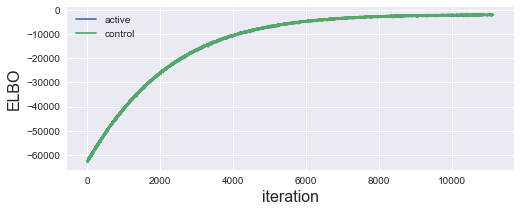

In [343]:
elbo_1 = -advi_active.hist
elbo_2 = -advi_control.hist

figsize = (8,3); fontsize = 16;
f, ax = plt.subplots(1,1,figsize=figsize);

ax.plot(elbo_1,label='active')
ax.plot(elbo_2,label='control')
ax.legend()
ax.set_ylabel('ELBO',fontsize=fontsize)
ax.set_xlabel('iteration',fontsize=fontsize);
sns.despine();

### Assess test performance

In [344]:
# Draw samples from variational posterior (the weights in the network)
n_draws = 200 # > 2k hangs for almost all network sizes on my 2018 MBP -SH
trace_control = approx_control.sample(draws=n_draws)
trace_active = approx_active.sample(draws=n_draws)

(n_test,n_input) = X_test.shape
test_x = theano.shared(X_test)
test_y = theano.shared(y_test)

# test active learning 
NN_model_test = construct_nn(test_x, test_y, n_input, n_output, n_test, n_hidden_1=128)
n_samples = 100
with NN_model_test:
    ppc_test_active = pm.sample_ppc(trace_active, samples=n_samples)

# test control
NN_model_test = construct_nn(test_x, test_y, n_input, n_output, n_test, n_hidden_1=128)
n_samples = 100
with NN_model_test:
    ppc_test_control = pm.sample_ppc(trace_control, samples=n_samples)

100%|██████████| 100/100 [00:57<00:00,  2.03it/s]


In [345]:
# Prediction is mode of each
test_y_pred_active = mode(ppc_test_active['out'], axis=0).mode[0,:]
test_y_pred_control = mode(ppc_test_control['out'], axis=0).mode[0,:]

mean_test_perf = np.mean(test_y_pred_active==y_test)
print("Network Test Set Performance Active Learning: {:f}".format(mean_test_perf))
mean_test_perf = np.mean(test_y_pred_control==y_test)
print("Network Test Set Performance Control: {:f}".format(mean_test_perf))

Network Test Set Performance Active Learning: 0.498600
Network Test Set Performance Control: 0.531900


Comparing the test performance, we see a tiny improvement with active learning relative to the control network. Below, we are plotting the number of training samples from each category that are used, and we can see that more samples are used from less certain categories. The error between the confusion matrix and the identity matrix is also very slightly lower with active learning and without. 

9658
9950


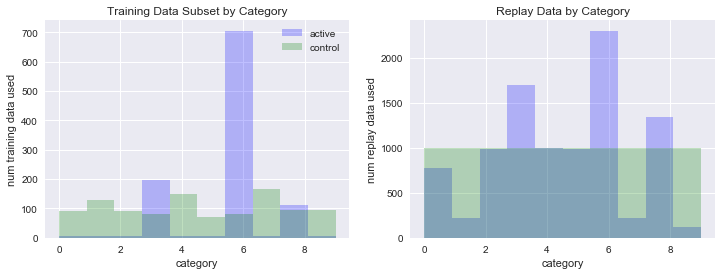

In [362]:
fig, ax = plt.subplots(1, 2, figsize=(12,4))

len_ind_used_active = [len(x) for x in ind_used_active]
len_ind_used_control = [len(x) for x in ind_used_control]

cat_used_active = [y_train[x.astype(int)] for x in ind_used_active]
cat_used_active = [item for cat in cat_used_active for item in cat]
cat_used_control = [y_train[x.astype(int)] for x in ind_used_control]
cat_used_control = [item for cat in cat_used_control for item in cat]

ax[0].hist(cat_used_active, bins=10, color='blue', alpha=.25, label='active')
ax[0].hist(cat_used_control, bins=10, color='green', alpha=.25, label='control')
ax[0].set_title('Training Data Subset by Category')
ax[0].set_xlabel('category')
ax[0].set_ylabel('num training data used')
ax[0].legend()

ax[1].hist(y_train[replay_ind_list_active.astype(int)], bins=10, color='blue', alpha=.25, label='active')
ax[1].hist(y_train[replay_ind_list_control.astype(int)], bins=10, color='green', alpha=.25, label='control')
ax[1].set_title('Replay Data by Category')
ax[1].set_xlabel('category')
ax[1].set_ylabel('num replay data used')
fig.show()

print(len(replay_ind_list_active))
print(len(replay_ind_list_control))

active error =  0.066549949732
control error =  0.068745160728


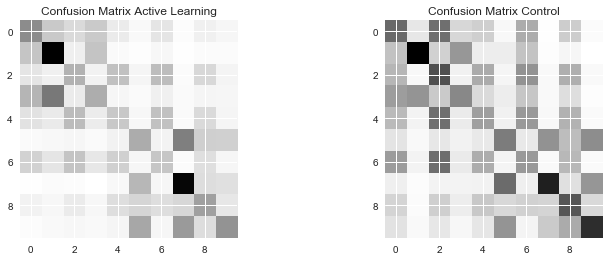

In [363]:
fig, ax = plt.subplots(1, 2, figsize=(12,4))

one_hot, cat_hist, cat_entropy, cat_KL = get_cat_entropy(X_test, y_test, ppc_test_active)
act_diff_identity = np.sum((cat_hist/np.sum(cat_hist) - np.eye(10)/10)**2)
ax[0].imshow(cat_hist)
ax[0].set_title('Confusion Matrix Active Learning')

one_hot, cat_hist, cat_entropy, cat_KL = get_cat_entropy(X_test, y_test, ppc_test_control)
cont_diff_identity = np.sum((cat_hist/np.sum(cat_hist) - np.eye(10)/10)**2)
ax[1].imshow(cat_hist)
ax[1].set_title('Confusion Matrix Control')

fig.show()

print('active error = ', act_diff_identity)
print('control error = ', cont_diff_identity)

Unfortunately, we really don't see an effect of active learning with this example. 

Though it is disappointing not to see a large effect of active learning in this example, it is not very surprising. This is a pretty contrived example, where we make the network intentionally less powerful by eliminating minibatches. It could be that this performance is jsut as well as it can do at this point. 

1) Larger data set
2) More complex task 

This is a relatively contrived example of using active learning, but it is a very useful concept. It is particularly useful when computation time is a limited resource relative to the data available. In this case it is very important to choose training data that will be most useful for improving performance. For example, in reinforcement learning type problems, an agent interacts witht the world in order to learn how to maximize its reward. Uncertainty can be used in this type of problem as a principled method for driving exploration. It is important for the agent to explore to avoid getting stuck in local minima, but one it is sufficiently certain about the environment it is better for the agent to reduce exploring and exploit the strategy that it has found to be best. 

Notes: 
- amount of data replayed from each category
- Need to deal with getting enough replay point at beginning, or at least making sure the control is the same